In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#paramaters
#change all units to: force = pN, length = nm, time = ms
pars = {}
pars['a00'] = -21*10**-3
pars['a01'] = 1
pars['a10'] = -1.348
pars['a11'] = -1
pars['gamma0'] = 8.72
pars['gamma1'] = 54.8

pars['kbT'] = 4.1
pars['noise0'] = 2*pars['gamma0']*pars['kbT']
pars['noise1'] = 4.916/(1e-3)

pars['delta_t'] = 0.01


In [3]:
(pars['a00']*pars['a11']) - (pars['a01']*pars['a10'])

1.369

In [4]:
def analytical_soln_acf_generic(omega_list, pars):

    autocorr_list = []
    for omega in omega_list:
        numerator = ( pars['a11']**2 * pars['noise0']**2 ) \
        + ( pars['a01']**2 * pars['noise1']**2 ) \
        + ( (omega**2) * (pars['gamma1']**2) * (pars['noise0']**2) )

        denominator = ( -2*pars['a11']*pars['a00']*pars['a10']*pars['a01'] ) \
        + ( (omega**2) * (pars['gamma0']**2) * (pars['a11']**2) ) \
        + ( ( (pars['a10']*pars['a01']) + (pars['gamma0']*pars['gamma1']* (omega**2) ) )**2) \
        + ( (pars['a00']**2) * ( (pars['a11']**2) + (omega**2) * (pars['gamma1']**2) ) )

        autocorr = numerator/denominator
        autocorr_list.append(autocorr)
    return autocorr_list

In [5]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 + (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] + \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((pars['noise0'])/((pars['gamma0'])**2))*s1
                 
        x2_new = x2 + (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] + \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((pars['noise1'])/((pars['gamma0'])**2))*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

In [6]:
def euler_n_traj(max_time, pars):
    min_time = 0
    n_time = int((max_time - min_time)/pars['delta_t']) #n_time = num of evenly spaced samples (ex. 1001 points)
    time = np.linspace(min_time, max_time, n_time) #time(ex. 0 (min time), 0.01, 0.02, ..., 10 (max time)) with n_time no. of data points
    
    x_traj_list = []
    y_traj_list = []
    for i in tqdm(range(pars['n_realizations'])):
        x_traj, y_traj = euler_one_traj(n_time, pars)
        x_traj_list.append(x_traj)
        y_traj_list.append(y_traj)
        
    return x_traj_list, y_traj_list, time

In [7]:
def plotter_traj(x_traj_list, y_traj_list):
    fig, ax = plt.subplots(1, 3, figsize=(15,3))

    for x in x_traj_list:
        ax[0].plot(time, x)
    for y in y_traj_list:
        ax[1].plot(time, y)
    for x,y in zip(x_traj_list, y_traj_list):
        ax[2].plot(x,y)

    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')

    ax[1].set_xlabel('t')
    ax[1].set_ylabel('y')

    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

In [8]:
#plot trajectories with t = 10s
pars['n_realizations'] = 50
length_plot = 500
x_traj_list, y_traj_list, time = euler_n_traj(length_plot, pars)

100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


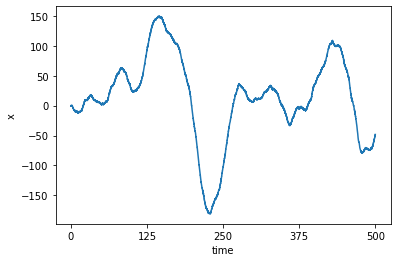

In [9]:
#Plot a sample trajectory
plt.plot(time, x_traj_list[1])
plt.xlabel('time')
plt.ylabel('x')
plt.xticks(np.linspace(0, length_plot, 5))
plt.show()

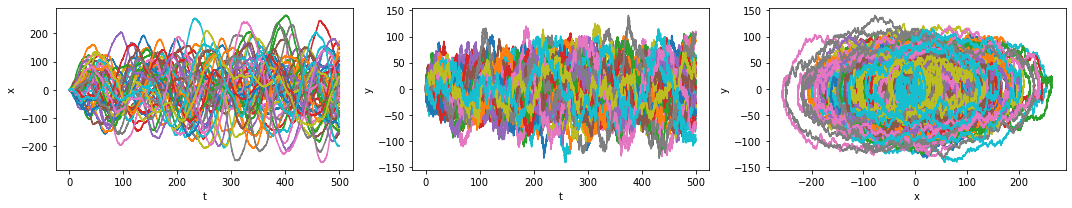

In [10]:
plotter_traj(x_traj_list, y_traj_list)

Calculate autocorrelation

In [11]:
len(x_traj_list[0])

50000

In [12]:
def autocorr(x):
    tau = np.arange(1,len(x_traj_list[0]), 50)
    
    corr_list = []
    for t in tau:
        xtau = np.roll(x, -t)
        
        product_list = []
        for x_value, xtau_value in zip(x, xtau):
            product = x_value*xtau_value
            product_list.append(product)
            
            
        corr = np.array(product_list[:-t]).mean()
        corr_list.append(corr)
    return corr_list

In [13]:
def ave_autocorr_traj(trajectory):
    autocorr_list = []
    for traj in trajectory:
        autocorr_traj = autocorr(traj)
        autocorr_list.append(autocorr_traj)
        
    matrix = np.array((autocorr_list))
    mean_per_column = matrix.mean(axis=0)
    
    return mean_per_column

In [14]:
%%time
xtraj = ave_autocorr_traj(x_traj_list)

Wall time: 12min 22s


In [15]:
normalization = np.mean((np.array(x_traj_list))*(np.array(x_traj_list)))
final_c = xtraj/normalization

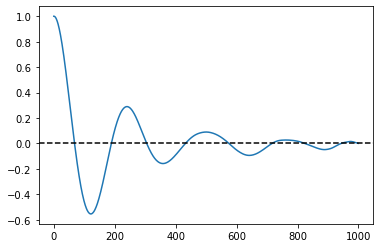

In [16]:
plt.plot(final_c)
plt.axhline(0, color='black', ls='dashed')
plt.show()

In [18]:
from numpy.fft import fft
import math

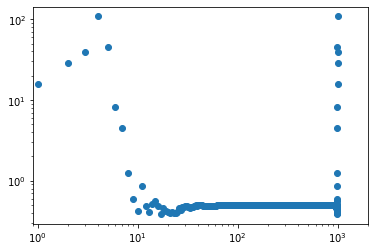

In [19]:
plt.xscale('log')
plt.yscale('log')
#apply fft to autocorrelation function
c_omega = fft(final_c)
#x axis is 1,2,3,..,1000
x = np.arange(len(c_omega))
#y values are all the datapoints
plt.scatter(x,c_omega.real)
plt.xlim(0.9, 2000)
plt.show()

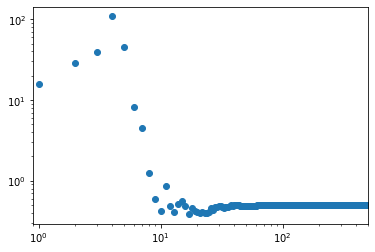

In [20]:
plt.xscale('log')
plt.yscale('log')
#apply fft to autocorrelation function
c_omega = fft(final_c)
#x axis is 1,2,3,..,500
x = np.arange(len(c_omega[0:500]))
plt.scatter(x,c_omega.real[0:500])
plt.xlim(0.9, 500)
plt.show()

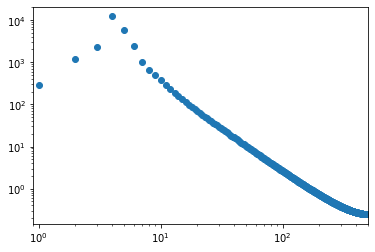

In [21]:
plt.xscale('log')
plt.yscale('log')
#apply fft to autocorrelation function
c_omega = fft(final_c)

# fft * np.conjugate (fft)
final = c_omega*np.conj(c_omega)

#x axis is 1,2,3,..,500
x = np.arange(len(final_c[0:500]))
#y values are only the first 500 data points
plt.scatter(x, final.real[0:500])

plt.xlim(0.9,500)
plt.show()

Calculate PSD

In [22]:
#number of blocks
num_blocks = 10
#freq = 1/delta_t
freq = 1/pars['delta_t']
#number of datapoints in each block
num_elements_block = math.floor(len(x_traj_list[0])/num_blocks)
#total time found in each block
tblock = num_elements_block/freq

print('num_elements_block', num_elements_block)
print('freq', freq)
print('tblock', tblock)

num_elements_block 5000
freq 100.0
tblock 50.0


In [23]:
def Lorentzian_psd(X, num_blocks, freq, num_elements_block):
    
    #total time found in each block
    tblock = num_elements_block/freq
    #divide trajectories into blocks
    blocks = np.array_split(X, num_blocks)
    #initialize psd to zero
    psd = np.zeros(num_elements_block)
    
    #loop for each block
    for index in range(num_blocks):
        #for each block, apply fft, multiply by complex conjugate, divide by frequency squared, divide by time of block
        psd_new = (fft(blocks[index])*np.conjugate(fft(blocks[index])))/(freq**2)/tblock  
        
        psd = psd + psd_new.real

    #take average
    return psd/num_blocks

In [24]:
#perform this for all realizations
psd_traj_list = []

#loop over all trajectories
for traj in x_traj_list:
    #apply lorentzian_psd function
    psd_traj = Lorentzian_psd(traj, num_blocks, freq, num_elements_block) 
    psd_traj_list.append(psd_traj)

#take the average for all realizations    
matrix = np.array((psd_traj_list))
mean_per_column = matrix.mean(axis=0)

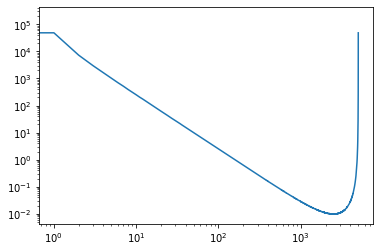

In [25]:
plt.xscale('log')
plt.yscale('log')
plt.plot(mean_per_column)
plt.show()